In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d',start='2017-4-1',end='2022-6-1',)
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03 00:00:00-04:00,33.768542,33.864879,33.613456,33.766190,79942800,0.0,0.0
2017-04-04 00:00:00-04:00,33.660443,34.045805,33.641644,34.017609,79565600,0.0,0.0
2017-04-05 00:00:00-04:00,33.888372,34.179745,33.792031,33.841377,110871600,0.0,0.0
2017-04-06 00:00:00-04:00,33.904823,33.958870,33.707443,33.756790,84596000,0.0,0.0
2017-04-07 00:00:00-04:00,33.773232,33.878971,33.665145,33.681591,66688800,0.0,0.0


In [3]:
#tickerDfResample = pd.DataFrame(tickerDf.resample('2d').sum())
#tickerDfResample[tickerDfResample == 0] = None
#tickerDfResample = tickerDfResample.interpolate(method='linear')
#tickerDfResample.index = pd.to_datetime(tickerDfResample.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
#tickerDfResample
tickerDfResample = tickerDf
#tickerDfResample = tickerDfResample.reset_index()

In [4]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2017-04-03 00:00:00-04:00 to 2022-05-31 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1300 non-null   float64
 1   High          1300 non-null   float64
 2   Low           1300 non-null   float64
 3   Close         1300 non-null   float64
 4   Volume        1300 non-null   int64  
 5   Dividends     1300 non-null   float64
 6   Stock Splits  1300 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 81.2 KB


In [5]:
first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
#tickerDf.Close.pct_change().dropna()
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference
Date,,,,,,,,
2017-04-03 00:00:00-04:00,33.768542,33.864879,33.613456,33.766190,79942800,0.0,0.0,0.251419
2017-04-04 00:00:00-04:00,33.660443,34.045805,33.641644,34.017609,79565600,0.0,0.0,-0.176231
2017-04-05 00:00:00-04:00,33.888372,34.179745,33.792031,33.841377,110871600,0.0,0.0,-0.084587
2017-04-06 00:00:00-04:00,33.904823,33.958870,33.707443,33.756790,84596000,0.0,0.0,-0.075199
2017-04-07 00:00:00-04:00,33.773232,33.878971,33.665145,33.681591,66688800,0.0,0.0,-0.039936
...,...,...,...,...,...,...,...,...
2022-05-24 00:00:00-04:00,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0,0.159515
2022-05-25 00:00:00-04:00,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0,3.250076
2022-05-26 00:00:00-04:00,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0,5.842178


In [6]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)

In [7]:
ad_test(tickerDfResample['FirstDifference'])

1. ADF:  -13.166536181078571
2. P_value:  1.275601949776801e-24
3. num_lags:  7
4. :  1292
5. crit_value:  {'1%': -3.4354214704688113, '5%': -2.863779629316101, '10%': -2.567962394851863}
	 1% :  -3.4354214704688113
	 5% :  -2.863779629316101
	 10% :  -2.567962394851863


In [8]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [9]:
stepwise_fit = auto_arima(tickerDfResample['Close'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5313.796, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5313.431, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5309.023, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5308.898, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5314.327, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5310.616, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5310.782, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5312.582, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5310.265, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.284 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1300
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2651.449
Date:                Tue, 24 Jan 2023   AIC                           5308.898
Time:                        12:08:57   BIC                           5324.406
Sample:                             0   HQIC                          5314.717
                               - 1300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0882      0.048      1.833      0.067      -0.006       0.183
ma.L1         -0.0717      0.017     -4.106      0.000      -0.106      -0.037
sigma2         3.4708      0.072     48.115      0.000       3.329       3.612
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1453.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              15.46   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
trainData = tickerDfResample['Close'][0:1260]
testData = pd.DataFrame(tickerDfResample['Close'][1260:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = ARIMA(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast()
    
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
 
    
    
 

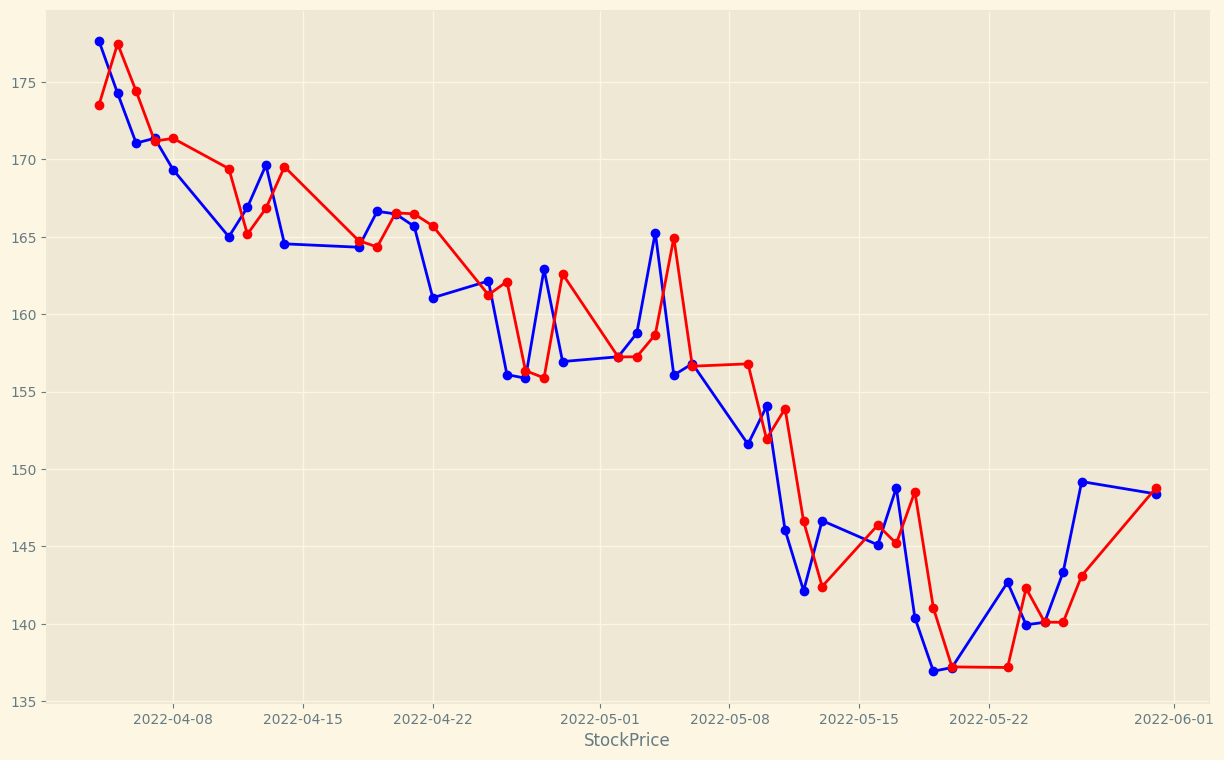

In [12]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(testData['Close'],'-bo')
plt.plot(testData['Predictions'],'-ro')

plt.xlabel("Date")
plt.xlabel("StockPrice")
plt.show()